In [3]:
from j2v import mag
from j2v import w2v
import numpy as np
import pandas as pd
import random
import json
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import re

Using Theano backend.


In [4]:
def cal_kendall_tau(list_1 , list_2):
    length = len(list_1)
    if length != len(list_2):
        return 'bad'
    set_1 = set()
    set_2 = set()
    for i in range(length):
        for j in range(i+1,length):
            set_1.add( (list_1[i],list_1[j]) )
            set_2.add( (list_2[i],list_2[j]) )
    concordant = len(set_1 & set_2)
    # (concordant - discordant) / total_pair
    return concordant * 2 / ((length * (length-1)) / 2) - 1

In [6]:
top = pd.read_csv(mag.get_path('top_journal_rank_all_candidate.csv'), header=0)

In [7]:
# the participants' names and emails are removed.
raw = pd.read_csv(mag.DATA_ROOT + "survey_resp_rank_j_6_10.csv", header=0, low_memory=False)

In [8]:
cols = raw.columns
col_target = {}
for col in cols:
    if re.search(r"Q\d{1,2}\.0_\d", col):
        question_text = raw.iloc[0][col]
        target = question_text.split(" - ")[1]
        col_target[col] = target

In [9]:
len(col_target)

260

In [10]:
raw = raw.iloc[2:, :]
raw.index = range(len(raw))

In [11]:
raw.shape

(367, 6048)

### 1. Unfinished

In [12]:
unfinish = raw.loc[raw['Finished'] == "False", :]
unfinish.index = range(len(unfinish))

In [11]:
# x people quit at Intro page;
# y people quit directly after selecting a discipline;
# z people quit during answering questions;

print("[ID]\t", "[# J.]\t", "[Selected Discipline]")
for i in range(len(unfinish)):
    print(i+1, "\t", np.sum(unfinish.iloc[i] == "Yes"), '\t', unfinish.iloc[i]['Q0.1'])

[ID]	 [# J.]	 [Selected Discipline]
1 	 0 	 Electrical Engineering & Computer Science
2 	 0 	 Health Professionals
3 	 0 	 Social Sciences
4 	 0 	 Electrical Engineering & Computer Science
5 	 0 	 Electrical Engineering & Computer Science
6 	 12 	 Social Sciences
7 	 0 	 Math & Physics
8 	 0 	 Electrical Engineering & Computer Science
9 	 0 	 Electrical Engineering & Computer Science
10 	 0 	 Humanities
11 	 0 	 Social Sciences
12 	 8 	 Social Sciences
13 	 0 	 Social Sciences
14 	 0 	 nan
15 	 4 	 Electrical Engineering & Computer Science
16 	 6 	 Social Sciences
17 	 0 	 Electrical Engineering & Computer Science
18 	 0 	 Electrical Engineering & Computer Science
19 	 12 	 Social Sciences
20 	 0 	 Social Sciences
21 	 0 	 nan
22 	 0 	 Social Sciences
23 	 0 	 Social Sciences
24 	 0 	 Electrical Engineering & Computer Science
25 	 7 	 Earth Sciences
26 	 0 	 Social Sciences
27 	 0 	 Health Professionals
28 	 0 	 Electrical Engineering & Computer Science
29 	 0 	 Humanities
30 	 0 	 Ele

### 2. Finished

In [13]:
finish = raw.loc[raw['Finished'] == "True", :]

In [14]:
len(finish)

247

#### 2.1 Unqualified or stopped due to quota

In [15]:
unqualify = finish.loc[np.sum(finish == "Yes", axis=1) < 3, :]
unqualify.index = range(len(unqualify))

In [15]:
print("[ID]\t", "[# J.]\t", "[Selected Discipline]")
for i in range(len(unqualify)):
    print(i+1, "\t", np.sum(unqualify.iloc[i] == "Yes"), '\t', unqualify.iloc[i]['Q0.1'])

[ID]	 [# J.]	 [Selected Discipline]
1 	 0 	 Electrical Engineering & Computer Science
2 	 2 	 Electrical Engineering & Computer Science
3 	 2 	 Social Sciences
4 	 1 	 Electrical Engineering & Computer Science
5 	 1 	 Electrical Engineering & Computer Science
6 	 1 	 Social Sciences
7 	 2 	 Electrical Engineering & Computer Science
8 	 0 	 Social Sciences
9 	 0 	 Electrical Engineering & Computer Science
10 	 1 	 Social Sciences
11 	 2 	 Electrical Engineering & Computer Science
12 	 1 	 Electrical Engineering & Computer Science
13 	 1 	 Electrical Engineering & Computer Science
14 	 2 	 Chemical, Mechanical, & Civil Engineering
15 	 2 	 Chemical, Mechanical, & Civil Engineering
16 	 1 	 Chemical, Mechanical, & Civil Engineering
17 	 0 	 Chemical, Mechanical, & Civil Engineering
18 	 0 	 Chemical, Mechanical, & Civil Engineering
19 	 0 	 Chemical, Mechanical, & Civil Engineering
20 	 1 	 Chemical, Mechanical, & Civil Engineering
21 	 2 	 Chemical, Mechanical, & Civil Engineering
22 	 0

#### 2.2 Qualified

In [16]:
response = finish.loc[np.sum(finish == "Yes", axis=1) >= 3, :]
response.index = range(len(response))

In [17]:
print("[ID]\t", "[# J.]\t", "[Selected Discipline]")
for i in range(len(response)):
    print(i+1, "\t", np.sum(response.iloc[i] == "Yes"), '\t', response.iloc[i]['Q0.1'])

[ID]	 [# J.]	 [Selected Discipline]
1 	 3 	 Health Professionals
2 	 6 	 Health Professionals
3 	 3 	 Electrical Engineering & Computer Science
4 	 4 	 Social Sciences
5 	 4 	 Social Sciences
6 	 4 	 Electrical Engineering & Computer Science
7 	 3 	 Social Sciences
8 	 8 	 Social Sciences
9 	 5 	 Social Sciences
10 	 4 	 Electrical Engineering & Computer Science
11 	 6 	 Math & Physics
12 	 6 	 Social Sciences
13 	 4 	 Social Sciences
14 	 5 	 Social Sciences
15 	 3 	 Electrical Engineering & Computer Science
16 	 3 	 Chemical, Mechanical, & Civil Engineering
17 	 4 	 Earth Sciences
18 	 12 	 Chemical, Mechanical, & Civil Engineering
19 	 4 	 Electrical Engineering & Computer Science
20 	 4 	 Biotechnology
21 	 10 	 Chemical, Mechanical, & Civil Engineering
22 	 11 	 Chemical, Mechanical, & Civil Engineering
23 	 5 	 Chemical, Mechanical, & Civil Engineering
24 	 6 	 Chemical, Mechanical, & Civil Engineering
25 	 4 	 Chemical, Mechanical, & Civil Engineering
26 	 3 	 Chemical, Mechanic

### 3. Qualified stat

In [17]:
len(response)

119

###  stat per discipline

In [18]:
discipline_response = defaultdict(lambda: [0, 0])
for i in range(len(response)):
    disc = response.iloc[i]['Q0.1']
    num_target = np.sum(response.iloc[i] == "Yes")
    discipline_response[disc][0] += 1
    discipline_response[disc][1] += num_target

In [19]:
# some targets have zero or one candidate in the ranked list, and they won't be used in the evaluation.
print("{:>50}{:>20}{:>35}".format("[Discipline]", "[# Participants]", "[Total # of selected targets]"))
for disc, (num_1, num_2) in discipline_response.items():
    print("{:>50}{:>20}{:>35}".format(disc, num_1, num_2))

                                      [Discipline]    [# Participants]      [Total # of selected targets]
                              Health Professionals                   2                                  9
         Electrical Engineering & Computer Science                  39                                224
                                   Social Sciences                  50                                318
                                    Math & Physics                   3                                 21
         Chemical, Mechanical, & Civil Engineering                  20                                129
                                    Earth Sciences                   2                                 10
                                     Biotechnology                   1                                  4
                                    Brain Research                   1                                  5
                                           Bio

###  list of responses per target

In [19]:
pattern = r"([a-zA-Z]),([a-zA-Z])"
match = re.compile(pattern)
# test = "Annual Review of Ecology, Evolution, and Systematics,BioScience,Good, Day"
# print(match.sub(r"\1||\2", test))

In [20]:
target_responses = defaultdict(list)

for i in range(len(response)):
    target_cols = cols[response.iloc[i] == "Yes"]
    for tcol in target_cols:
        target = col_target[tcol]
        pref = tcol.split(".")[0] + "." + tcol.split("_")[1]
        col_rank = pref + "_0_GROUP"
        col_unfa = pref + "_1_GROUP"
        rank_j_text = response.iloc[i][col_rank]
        rank_j_list = []
        if not pd.isnull(rank_j_text):
            # if there is only one journal in the text, then it will return the original string.
            rank_j_text = match.sub(r"\1||\2", rank_j_text)
            rank_j_list = rank_j_text.split("||")
        unfa_j_text = response.iloc[i][col_unfa]
        unfa_j_list = []
        if not pd.isnull(unfa_j_text):
            unfa_j_text = match.sub(r"\1||\2", unfa_j_text)
            unfa_j_list = unfa_j_text.split("||")
        resp = {"rank": rank_j_list, "unfamiliar": unfa_j_list}
        target_responses[target].append(resp)

In [21]:
target_algo_ranks = dict()

for i in range(len(top)):
    jname, pr_disc, citation, j2v_alg = top.iloc[i][['jname', 'pr_disc', 'citation', 'j2v']]
    tem = {}
    tem['pr_disc'] = pr_disc.split("||")
    tem['citation'] = citation.split("||")
    tem['j2v'] = j2v_alg.split("||")
    target_algo_ranks[jname] = tem

## Agreement

In [22]:
target_rank_agreement = {}

for target, resps in target_responses.items():
    agreement = []
    rank_list = [resp['rank'] for resp in resps]
    for i in range(len(rank_list)):
        for j in range(i+1, len(rank_list)):
            intersect = set(rank_list[i]) & set(rank_list[j])
            if len(intersect) >= 2:
                list_1 = [jj for jj in rank_list[i] if jj in intersect]
                list_2 = [jj for jj in rank_list[j] if jj in intersect]
                agreement.append(cal_kendall_tau(list_1, list_2))
    target_rank_agreement[target] = (len(resps), agreement)

In [22]:
alist = []
blist = []
for target, (num, agreement) in target_rank_agreement.items():
    if len(agreement) > 0:
        alist.append(np.mean(agreement))
        blist.extend(agreement)
print("avg of avg agreement per target:", np.mean(alist))
print("overall avg agreement:", np.mean(blist))

avg of avg agreement per target: 0.14367455086915734
overall avg agreement: 0.2683465424982164


In [23]:
np.max(alist)

1.0

### Agreement per discipline

In [40]:
jname_disc = pd.Series(top.disc_name.values, index=top.jname).to_dict()

In [34]:
alist = []
blist = []
for target, resps in target_responses.items():
    if jname_disc[target] == "Social Sciences":
        agreement = []
        rank_list = [resp['rank'] for resp in resps]
        for i in range(len(rank_list)):
            for j in range(i+1, len(rank_list)):
                intersect = set(rank_list[i]) & set(rank_list[j])
                if len(intersect) >= 2:
                    list_1 = [jj for jj in rank_list[i] if jj in intersect]
                    list_2 = [jj for jj in rank_list[j] if jj in intersect]
                    agreement.append(cal_kendall_tau(list_1, list_2))
        if len(agreement) > 0:
            alist.append(np.mean(agreement))
            blist.extend(agreement)
print("avg of avg agreement per target:", np.mean(alist))
print("overall avg agreement:", np.mean(blist))

avg of avg agreement per target: 0.34005523574664864
overall avg agreement: 0.3693194150963804


In [35]:
alist = []
blist = []
for target, resps in target_responses.items():
    if jname_disc[target] == "Chemical, Mechanical, & Civil Engineering":
        agreement = []
        rank_list = [resp['rank'] for resp in resps]
        for i in range(len(rank_list)):
            for j in range(i+1, len(rank_list)):
                intersect = set(rank_list[i]) & set(rank_list[j])
                if len(intersect) >= 2:
                    list_1 = [jj for jj in rank_list[i] if jj in intersect]
                    list_2 = [jj for jj in rank_list[j] if jj in intersect]
                    agreement.append(cal_kendall_tau(list_1, list_2))
        if len(agreement) > 0:
            alist.append(np.mean(agreement))
            blist.extend(agreement)
print("avg of avg agreement per target:", np.mean(alist))
print("overall avg agreement:", np.mean(blist))

avg of avg agreement per target: 0.07966536647078519
overall avg agreement: 0.1254315838257444


In [36]:
alist = []
blist = []
for target, resps in target_responses.items():
    if jname_disc[target] == "Electrical Engineering & Computer Science":
        agreement = []
        rank_list = [resp['rank'] for resp in resps]
        for i in range(len(rank_list)):
            for j in range(i+1, len(rank_list)):
                intersect = set(rank_list[i]) & set(rank_list[j])
                if len(intersect) >= 2:
                    list_1 = [jj for jj in rank_list[i] if jj in intersect]
                    list_2 = [jj for jj in rank_list[j] if jj in intersect]
                    agreement.append(cal_kendall_tau(list_1, list_2))
        if len(agreement) > 0:
            alist.append(np.mean(agreement))
            blist.extend(agreement)
print("avg of avg agreement per target:", np.mean(alist))
print("overall avg agreement:", np.mean(blist))

avg of avg agreement per target: 0.2013037953572184
overall avg agreement: 0.1003631289345575


## Append unfamiliar ones

In [76]:
frac_unfa = []

for target, resps in target_responses.items():
    for resp in resps:
        total = len(resp['unfamiliar']) + len(resp['rank'])
        frac_unfa.append(len(resp['unfamiliar'])/total)

In [77]:
# the average fraction of candidate journals put into the Unfamiliar bucket.
np.mean(frac_unfa)

0.41480739582654774

### All targets (combined)

In [279]:
labels_dict = {'pr_disc': 'disc.', 'citation': 'cv', 'j2v': 'p2v'}

In [275]:
algo_rank_corr = defaultdict(list)
agree_thsh = 0.2

for target, resps in target_responses.items():
    num_resp, agreement = target_rank_agreement[target]
    if len(agreement) > 0 and np.mean(agreement) >= agree_thsh:
        for resp in resps:
            rank_j = resp['rank'].copy()
            unfa_j = resp['unfamiliar'].copy()
            rank_j.extend(random.sample(unfa_j, len(unfa_j)))
            if len(rank_j) >= 2:
                pr_disc_rank = [j for j in target_algo_ranks[target]['pr_disc'] if j in rank_j]
                missing_j = [jj for jj in rank_j if jj not in pr_disc_rank]
                random.shuffle(missing_j)
                pr_disc_rank.extend(missing_j)
                citation_rank = [j for j in target_algo_ranks[target]['citation'] if j in rank_j]
                j2v_rank = [j for j in target_algo_ranks[target]['j2v'] if j in rank_j]
                pr_disc_cor = cal_kendall_tau(pr_disc_rank, rank_j)
                cit_cor = cal_kendall_tau(citation_rank, rank_j)
                j2v_cor = cal_kendall_tau(j2v_rank, rank_j)
                algo_rank_corr['pr_disc'].append(pr_disc_cor)
                algo_rank_corr['citation'].append(cit_cor)
                algo_rank_corr['j2v'].append(j2v_cor)

total evaluatable targets (with duplicates):  407


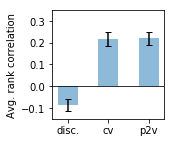

In [280]:
fig, ax = plt.subplots(figsize = (2, 2))
x_pos, labels, avgs, stds, counts = [], [], [], [], []

for i, (algo, corrs) in zip(range(len(algo_rank_corr)), algo_rank_corr.items()):
    x_pos.append(i)
    counts.append(len(corrs))
    labels.append(labels_dict[algo])
    avgs.append(np.mean(corrs))
    stds.append(np.std(corrs))

print("total evaluatable targets (with duplicates): ", counts[0])
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}
ax.axhline(y=0, color='k', linewidth=0.8)
ax.bar(x_pos, avgs, yerr=CIs['95']*(stds/np.sqrt(counts)), width = 0.5, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Avg. rank correlation')
# ax.yaxis.grid(True)
ax.set_ylim(-0.15, 0.35)
# ax.set_title("Algo. vs. Human")
plt.show()
fig.savefig('avg_rank_corr_all.pdf', bbox_inches='tight', pad_inches=0)

### Per discipline

In [281]:
def cal_corr_per_disc(discipline, agree_thsh = 0.2):
    algo_rank_corr = defaultdict(list)

    for target, resps in target_responses.items():
        if jname_disc[target] == discipline:
            num_resp, agreement = target_rank_agreement[target]
            if len(agreement) > 0 and np.mean(agreement) >= agree_thsh:
                for resp in resps:
                    rank_j = resp['rank'].copy()
                    unfa_j = resp['unfamiliar'].copy()
                    rank_j.extend(random.sample(unfa_j, len(unfa_j)))
                    if len(rank_j) >= 2:
                        pr_disc_rank = [j for j in target_algo_ranks[target]['pr_disc'] if j in rank_j]
                        missing_j = [jj for jj in rank_j if jj not in pr_disc_rank]
                        random.shuffle(missing_j)
                        pr_disc_rank.extend(missing_j)
                        citation_rank = [j for j in target_algo_ranks[target]['citation'] if j in rank_j]
                        j2v_rank = [j for j in target_algo_ranks[target]['j2v'] if j in rank_j]
                        pr_disc_cor = cal_kendall_tau(pr_disc_rank, rank_j)
                        cit_cor = cal_kendall_tau(citation_rank, rank_j)
                        j2v_cor = cal_kendall_tau(j2v_rank, rank_j)
                        algo_rank_corr['pr_disc'].append(pr_disc_cor)
                        algo_rank_corr['citation'].append(cit_cor)
                        algo_rank_corr['j2v'].append(j2v_cor)
    return algo_rank_corr

In [282]:
def plot_per_disc(algo_rank_corr, title, fname):
    
    fig, ax = plt.subplots(figsize = (2, 2))
    x_pos, labels, avgs, stds, counts = [], [], [], [], []

    for i, (algo, corrs) in zip(range(len(algo_rank_corr)), algo_rank_corr.items()):
        x_pos.append(i)
        counts.append(len(corrs))
        labels.append(labels_dict[algo])
        avgs.append(np.mean(corrs))
        stds.append(np.std(corrs))

    print("total evaluatable targets (with duplicates): ", counts[0])
    CIs = {'90': 1.645, '95': 1.96, '99': 2.576}
    ax.bar(x_pos, avgs, yerr=CIs['95']*(stds/np.sqrt(counts)), width = 0.5, align='center', alpha=0.5, ecolor='black', capsize=3)
    ax.axhline(y=0, color='k', alpha=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_ylim(-0.25, 0.4)
#         ax.tick_params(axis='y', direction='in')
#         ax.get_yaxis().set_ticklabels([])
    ax.set_ylabel('Avg. rank correlation')
    ax.set_title(title)
    plt.show()
    fig.savefig('avg_rank_corr_%s.pdf'%fname, bbox_inches='tight', pad_inches=0)

total evaluatable targets (with duplicates):  292


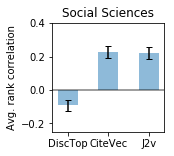

In [249]:
algo_rank_corr = cal_corr_per_disc('Social Sciences', agree_thsh=0.2)
plot_per_disc(algo_rank_corr, 'Social Sciences', 'social')

total evaluatable targets (with duplicates):  96


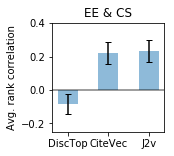

In [250]:
algo_rank_corr = cal_corr_per_disc('Electrical Engineering & Computer Science', agree_thsh=0.2)
plot_per_disc(algo_rank_corr, 'EE & CS', 'eecs')

total evaluatable targets (with duplicates):  17


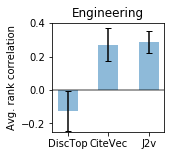

In [252]:
algo_rank_corr = cal_corr_per_disc('Chemical, Mechanical, & Civil Engineering', agree_thsh=0.2)
plot_per_disc(algo_rank_corr, 'Engineering', 'eng')

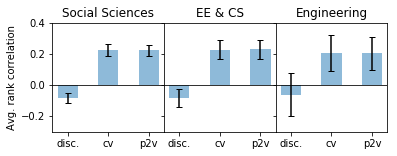

In [285]:
def ax_helper(ax, algo_rank_corr, title):
    x_pos, labels, avgs, stds, counts = [], [], [], [], []
    for i, (algo, corrs) in zip(range(len(algo_rank_corr)), algo_rank_corr.items()):
        x_pos.append(i)
        counts.append(len(corrs))
        labels.append(labels_dict[algo])
        avgs.append(np.mean(corrs))
        stds.append(np.std(corrs))
    CIs = {'90': 1.645, '95': 1.96, '99': 2.576}
    ax.axhline(y=0, color='k', linewidth=0.8)
    ax.bar(x_pos, avgs, yerr=CIs['95']*(stds/np.sqrt(counts)), width = 0.5, align='center', alpha=0.5, ecolor='black', capsize=3)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_ylim(-0.3, 0.4)
    ax.set_title(title)
#     for tick in ax.get_xticklabels():
#         tick.set_ha('right')
#         tick.set_fontsize(8)
#         tick.set_rotation(25)

fig, axes = plt.subplots(figsize = (6, 2), nrows=1, ncols=3, sharey='row')

algo_rank_corr = cal_corr_per_disc('Social Sciences', agree_thsh=0.2)
ax_helper(axes[0], algo_rank_corr, 'Social Sciences')
axes[0].set_ylabel('Avg. rank correlation')

algo_rank_corr = cal_corr_per_disc('Electrical Engineering & Computer Science', agree_thsh=0.2)
ax_helper(axes[1], algo_rank_corr, 'EE & CS')

algo_rank_corr = cal_corr_per_disc('Chemical, Mechanical, & Civil Engineering', agree_thsh=0.2)
ax_helper(axes[2], algo_rank_corr, 'Engineering')

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()
fig.savefig('avg_rank_corr_three_disc.pdf', bbox_inches='tight', pad_inches=0)